In [49]:
# 24/01/2024
# 4.5 Entrenamiento de un clasificador textual converted CIE

# Es de un KAGGLE :D
# pip install seaborn

# Detección de correos SPAM


A continuación se muestra un estudio sobre un filtrado de correos de spam. Se trata de una comparativa de diversos algoritmos de aprendizaje supervisados de clasificación. Previo a este estudio se ha limpiado el texto y se ha hecho uso del Procesamiento del Lenguaje Natural con la libreria *SpaCy* para tokenizar, lemmatizar y vectorizar textos para una mayor facilidad de análisis.


El procedimiento seguido es el siguiente: 

0. Se importa la base de datos 
1. Limpieza y preprocesado del dataset
2. Tokenización 
3. Lemmatización
4. Vectorizacion
5. Aplicación de los diferentes algoritmos y visualización de sus resultados
6. Comparación de los algoritmos y conclusiones


Datos sacados de: (https://www.kaggle.com/code/ranzeet013/spam-message-classification-acc-0-94)

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## Importamos sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


## Vectorizacion
from sklearn.feature_extraction.text import TfidfVectorizer


## Para aplicar modelos de prediccion
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree


## Para evaluar los resultados. 
from sklearn.metrics import f1_score


## Bibliotecas para preprocesar el texto
import re


## Importamos NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize


## Importamos spacy
import spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AlejandroDiezRedondo\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AlejandroDiezRedondo\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


## 0. Lectura de la base de datos

Para este estudio se ha utilizado una base de datos que recoge un total de 5572 correos, etiquetados todos ellos como SPAM O HAM (no spam)

In [51]:
df_spam = pd.read_csv('spam.csv')
df_spam

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Se codifica la variable objetido de modo que la clase que nos interesa (SPAM) se establezca con un 1 y HAM con un 0. 

In [52]:
## Creacion columna clase
def category_to_numeric(category):
    if category == 'ham':
        return 0
    elif category == 'spam':
        return 1
    else:
        return None  # Puedes ajustar esto según tus necesidades

# Crear la nueva columna 'Category_Numeric'
df_spam['Class'] = df_spam['Category'].apply(category_to_numeric)


In [53]:
df_spam = df_spam.drop(['Category'], axis =1)
df_spam

,Message,Class
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will ü b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


## 1. Preprocesamiento y normalizacion de los datos
En este apartado, se preprocesa y normaliza el texto, de modo que podamos tenerlo lo más estandarizado posible.

Primero se eliminan los signos de puntuación innecesarios, se convierten todas las palabras a minusculas, se eliminan enlaces, dobles espacios...

Para llevar a cabo esta limpieza se crea la función *wordopt*, compuesta por distintas instrucciones en forma de expresiones regulares que permiten llevar a cabo la limpieza de una forma eficiente.

La función *eliminar_arroba_hashtag* permite eliminar estructuras del tipo @usuario y #hashtag.

In [54]:
## crear un dataframe nuevo para modificarlos
df_para_limpiar = df_spam.copy()

In [55]:
def wordopt(text):
    text = text.lower()  # Convierte el texto a minúsculas
    text = re.sub('https?://\S+|www\.\S+', '', text)  # Borra URLs
    text = re.sub('\n', ' ', text)  # Borra saltos de línea
    text = re.sub(r'\s+', ' ', text)  # Borra varios espacios en blanco y los sustituye por uno solo
    text = re.sub('<.*?>', '', text)  # Borra tags HTML
    text = re.sub('\[.*?\]', '', text)  # Borra corchetes y su contenido
    text = re.sub(r'\d+(\.\d+)?', '', text)  # Borra números, incluyendo decimales
    text = re.sub(r'\b\d+\w+\b', '', text)  # Borra números seguidos de letras (como "2nd")
    text = re.sub(r'[£$%&\'()*+,-/:;<=>@[\]^_`{|}~¿¡—“”‘’]', '', text)  # Borra signos de puntuación, exclamaciones, interrogaciones y otros símbolos
    text = re.sub(r'"', '', text)  # Borra comillas
    text = re.sub(r'\s+', ' ', text)  # Borra dobles espacios finales
    return text


def eliminar_arroba_hashtag(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    
    return text

In [56]:
df_para_limpiar["Message"] = df_para_limpiar["Message"].apply(wordopt)
df_para_limpiar["Message"] = df_para_limpiar["Message"].apply(eliminar_arroba_hashtag)


A continuación se muestra una comparación de texto antes y después de aplicarle las funciones de preprocesamiento, para que pueda comprenderse mejor lo que se está realizando.


In [57]:
import random

m = random.randint(0,len(df_spam)-1)

print('El texto sin preprocesar:')
print('\t',df_spam["Message"][m])

print('')
print('')

print('El texto preprocesado:')
print('\t',df_para_limpiar["Message"][m])

El texto sin preprocesar:
	 There'll be a minor shindig at my place later tonight, you interested?


El texto preprocesado:
	 therell be a minor shindig at my place later tonight you interested?


Creamos una copia del dataframe con el texto ya preprocesado para proceder con el análisis sin modificar el anterior por si se necesita acceder a él.

In [58]:
df_limpio = df_para_limpiar.copy()

## 3. Lemmatización

Como ya se vio en una de las clases anteriores, la lemmatización consite en obtener el lema de las palabras, de modo que se consiga reducir el ruido y la dimensionalidad del vocabulario para poder mejorar la eficiencia del modelo. Crearemos una función que se encarge de realizar este proceso. Se ha escogido la lematización en vez de la técnica stemming, debido a su eficiencia ante palabras similares con diferente raíz.

In [59]:
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [60]:
df_limpio['Message'] = df_limpio['Message'].apply(lemmatize_text)


In [61]:
df_limpio

,Message,Class
0,go until jurong point crazy available only in ...,0
1,ok lar joke wif u oni,0
2,free entry in a wkly comp to win fa cup final ...,1
3,u dun say so early hor u c already then say,0
4,nah I do not think he go to usf he live around...,0
...,...,...
5567,this be the nd time we have try contact u u ha...,1
5568,will ü b go to esplanade fr home ?,0
5569,pity be in mood for that soany other suggestion ?,0
5570,the guy do some bitching but I act like i d be...,0


Análogo a lo que se hizo anteriormente, en la siguiente celda puede observarse los cambios realizados.

In [62]:
m = random.randint(0,len(df_limpio)-1)

print('El texto previo a la lematización:')
print('\t',df_para_limpiar["Message"][m])

print('')
print('')

print('El texto lematizado:')
print('\t',df_limpio["Message"][m])

El texto previo a la lematización:
	 haha that was the first person i was gonna ask


El texto lematizado:
	 haha that be the first person I be go to ask


### Stopwords

Las stopwords son palabras comunes que suelen eliminarse durante el preprocesamiento del texto, ya que aportan poco significado a un texto y no suelen ser relevantes para el análisis. En el presente estudio, se ha decidido eliminarlas, y para ello, se hará uso de la biblioteca NLTK y su diccionario de stopword en ingles.


In [63]:
def tokenization_stopwords (tokens_spell_checked):
    text = word_tokenize(tokens_spell_checked)
    text = [word for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    return text

df_limpio['Message'] = df_limpio['Message'].apply(tokenization_stopwords)


Ahora podemos ver como quedarían nuestros emails tras la eliminación de las *Stopwords*

In [64]:
m = random.randint(0,len(df_limpio)-1)

print('El texto sin el eliminado de stopwords:')
print('\t',df_para_limpiar["Message"][m])

print('')
print('')

print('El texto tras el eliminado de stopwprds:')
print('\t',df_limpio["Message"][m])

El texto sin el eliminado de stopwords:
	 after my work ah den plus lor u workin oso rite den go orchard lor no other place to go liao


El texto tras el eliminado de stopwprds:
	 work ah den plus lor u workin oso rite den go orchard lor place go liao


## 4. Vectorización

### Word Embeding

Para poder aplicar los distintos algoritmos de clasificación, debemos vectorizar el texto, de modo que la entrada al algoritmo sea una variable numérica. En este caso, estaremos utilizando TfidfVectorizer, una técnica que crea vectores de características ponderadas utilizando TF-IDF (Term Frequency-Inverse Document Frequency). A diferencia de los word embeddings, que representan palabras en un espacio semántico continuo, el enfoque de TF-IDF se centra en la importancia relativa de una palabra en un documento dentro de un conjunto más amplio de documentos. Esta técnica pondera las palabras según su frecuencia en un documento específico y su rareza en todo el corpus, lo que permite capturar la relevancia de cada palabra en la representación vectorial resultante. Aunque es diferente de los word embeddings, TfidfVectorizer es útil para capturar la relevancia contextual y la importancia de las palabras en el análisis de texto.

In [65]:
vectorizer = TfidfVectorizer()
y = df_limpio['Class']
X = df_limpio['Message']

X_vect = vectorizer.fit_transform(X)


La vectorización realizada por TfidfVectorizer genera características ponderadas basadas en la frecuencia de los términos y la inversa de la frecuencia del documento (TF-IDF). Estas características ya tienen un significado relativo y están normalizadas en cierto grado por la forma en que se calculan, por lo que no es necesario aplicar un escalado adicional antes de usarlas como entrada para un modelo de regresión logística.

## División del dataset

A continuación se dividen los datos en *train* y *test*. Primero, el modelo se ajusta a estos datos, lo que significa que se adapta a los patrones y relaciones en el conjunto de entrenamiento. En el dataset de *test* se evalua el rendimiento del modelo con unos datos nuevos.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.20, random_state=18)

## 5. Modelos de predicción:

A continuación se van a aplicar los siguientes algoritmos supervisados para la predicción de mensajes SPAM / NO SPAM (HAM). Después se comparan los resultados y se explicará cuál es el más adecuado:

- 5.1 Regresión Logística
- 5.2 Naive Bayes
- 5.3 K - Nearest Neighbors (KNN)
- 5.4 Árbol de decisión


### 5.1 Regresión logística

In [67]:
###### Se declara el modelo
LR = LogisticRegression()

##### Se entrena el modelo
LR.fit(X_train,y_train)

#### Una vez entrenado, se realiza la predicción
y_rl_pred = LR.predict(X_test)

In [68]:
print("Resumen de las distintas métricas:\n\n", classification_report(y_test, y_rl_pred))

Resumen de las distintas métricas:

               precision    recall  f1-score   support

           0       0.96      1.00      0.98       977
           1       0.97      0.72      0.82       138

    accuracy                           0.96      1115
   macro avg       0.97      0.86      0.90      1115
weighted avg       0.96      0.96      0.96      1115



Precisión: 0.9623318385650225

Valores de la matriz de consusión: 
 [[974   3]
 [ 39  99]]


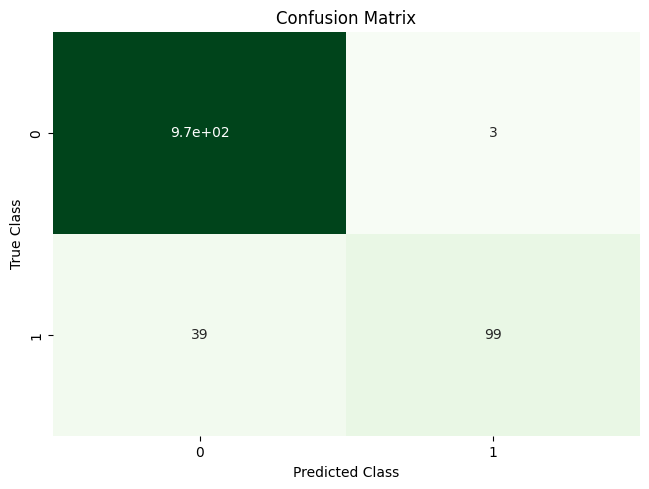

In [69]:
print("Precisión:", accuracy_score(y_test, y_rl_pred))
print('')

#### Se visualiza su matriz de conclusión.
matrix = confusion_matrix(y_test, y_rl_pred)
print('Valores de la matriz de consusión: \n', matrix)

sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens")

plt.title("Confusion Matrix"), 
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

### 5.2 Naive Bayes

In [70]:
###### Se declara el modelo
nb = GaussianNB()

X_train_array = X_train.toarray()
X_test_array = X_test.toarray()


##### Se entrena
nb.fit(X_train_array, y_train)


##### Una vez entrenado, se realiza la predicción
y_nb_pred = nb.predict(X_test_array)

In [71]:
print("Resumen de las distintas métricas: \n", classification_report(y_test, y_nb_pred))

Resumen de las distintas métricas: 
               precision    recall  f1-score   support

           0       0.98      0.86      0.92       977
           1       0.47      0.88      0.61       138

    accuracy                           0.86      1115
   macro avg       0.73      0.87      0.77      1115
weighted avg       0.92      0.86      0.88      1115



Precisión: 0.863677130044843

Valores de la matriz de consusión: 
 [[842 135]
 [ 17 121]]


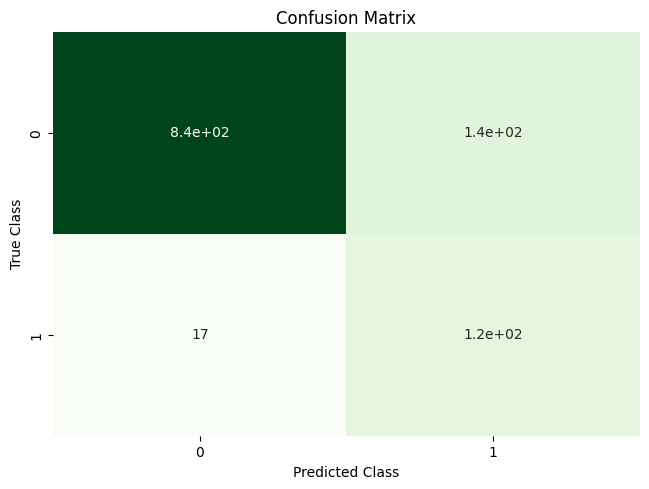

In [72]:
print("Precisión:", accuracy_score(y_test, y_nb_pred))
print('')

#### Se visualiza su matriz de confusión.
matrix =confusion_matrix(y_test, y_nb_pred)
print('Valores de la matriz de consusión: \n', matrix)

sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens")

plt.title("Confusion Matrix"), 
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

### 5.3 K-Nearest Neigbors

In [73]:
def plot_complexity_curve(k_list, knn_model, X_knn_train_esc, X_knn_test_esc, y_knn_train, y_knn_test):
    "'Función para escoger el mejor valor de k'"
    train_scores = []
    test_scores = []
    
    # For each k
    for k in k_list:
        
        # Initialize
        knn = knn_model(k)
        
        # fit
        knn.fit(X_knn_train_esc, y_knn_train)
        
        # predict
        train_scores.append(knn.score(X_knn_train_esc, y_knn_train))
        test_scores.append(knn.score(X_knn_test_esc, y_knn_test))
    
    # Plot
    fig, ax = plt.subplots()
    
    ax.plot(k_list, train_scores, label='Training Accuracy', color='red')
    ax.plot(k_list, test_scores, label='Testing Accuracy', color='black')

    ax.set(title='k-NN with Different Values for $k$',
           xlabel='Number of Neighbors',
           ylabel='Accuracy')
    
    ax.legend()

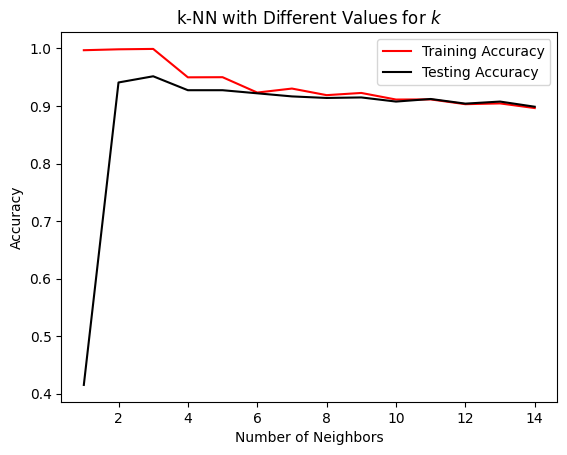

In [74]:
##### Visualizamos la respuesta para k entre 1-15
neighbors = np.arange(1, 15)
plot_complexity_curve(neighbors, KNeighborsClassifier, X_train, 
                      X_test, y_train, y_test)

In [75]:
# Crear un clasificador K-NN con un valor de K = 3
k = 3
knn_classifier = KNeighborsClassifier(n_neighbors=k)

In [76]:
# Ajustar el modelo a los datos de entrenamiento
knn_classifier.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = knn_classifier.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo K-NN con K = {k}: {accuracy * 100:.2f}%")

Precisión del modelo K-NN con K = 3: 95.16%


In [77]:
#### Se declara el modelo a utilizar
knn = KNeighborsClassifier(n_neighbors = 8)

##### Se entrena
knn.fit(X_train, y_train)

##### Una vez entrenado, se realiza la predicción
y_knn_pred = knn.predict(X_test)

Precisión con KNN (K=8) : 0.9139013452914798

Valores de la matriz de consusión: 
 [[977   0]
 [ 96  42]]


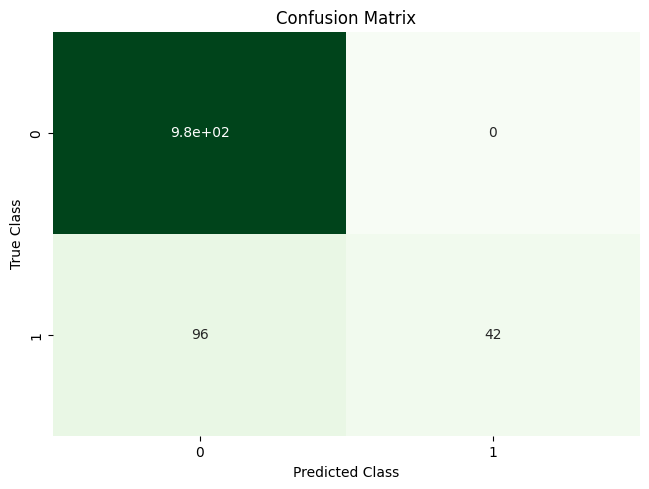

In [78]:
print("Precisión con KNN (K=8) :", accuracy_score(y_test,y_knn_pred))
print('')

#### Se visualiza su matriz de conclusión
matrix = confusion_matrix(y_test, y_knn_pred)
print('Valores de la matriz de consusión: \n', matrix)

sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens")

plt.title("Confusion Matrix"), 
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

### 5.4 Árbol de decisión

In [79]:
#### Se declara el modelo a utilizar
decision_tree = tree.DecisionTreeClassifier(criterion='gini')

##### Se entrena
decision_tree.fit(X_train, y_train)

##### Una vez entrenado, se realiza la predicción
y_add_pred = decision_tree.predict(X_test)

In [80]:
print("Resumen de las distintas métricas: \n", classification_report(y_test, y_add_pred))

Resumen de las distintas métricas: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       977
           1       0.83      0.83      0.83       138

    accuracy                           0.96      1115
   macro avg       0.90      0.90      0.90      1115
weighted avg       0.96      0.96      0.96      1115



Precisión: 0.957847533632287

Valores de la matriz de consusión: 
 [[953  24]
 [ 23 115]]


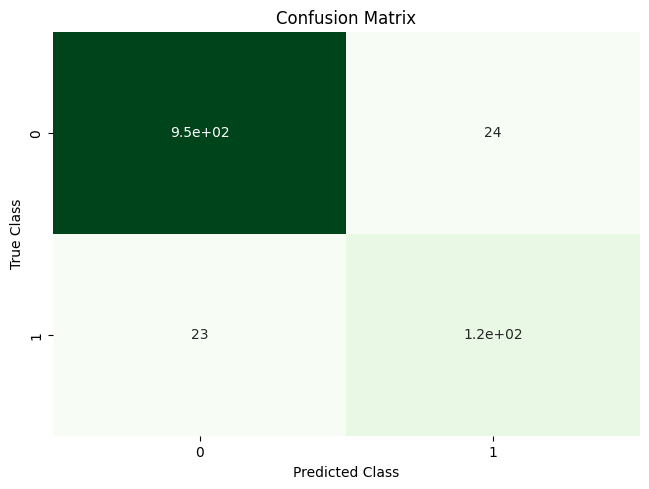

In [81]:
print("Precisión:", accuracy_score(y_test,y_add_pred))
print('')

#### Se visualiza su matriz de confusión
matrix = confusion_matrix(y_test, y_add_pred)
print('Valores de la matriz de consusión: \n', matrix)

sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens")

plt.title("Confusion Matrix"), 
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

## 6. Comparación de los resultados obtenidos:

In [82]:
df_resumen_resultados = pd.DataFrame()
accuracy_ = []
f1_ = []
lista_pred = [y_rl_pred, y_nb_pred, y_knn_pred, y_add_pred]

for i in range(0, len(lista_pred)):
    accuracy_.append(accuracy_score(y_test, lista_pred[i]))
    f1_.append(f1_score(y_test, lista_pred[i], average = 'weighted'))


In [83]:
df_resumen_resultados['Algoritmo'] = ['Logistic Regression','Naive Bayes','K-NN','Decision Tree']
df_resumen_resultados['Accuracy'] = accuracy_
df_resumen_resultados['F1_score'] = f1_

df_resumen_resultados

,Algoritmo,Accuracy,F1_score
0,Logistic Regression,0.962332,0.959847
1,Naive Bayes,0.863677,0.879710
2,K-NN,0.913901,0.892958
3,Decision Tree,0.957848,0.957913


### Conclusiones: 

Viendo los anteriores resultados podemos decir que los mejores métodos predictivos son: **Árbol de decisión** y **la regresion logística**.
Es recomendable de hecho prestar más atención a la metrica f1_score, ya que el problema de filtrado de spams, suele tender a presentar clases desbalanceadas. No obstante, en cada **classification_report** pueden observarse todas las métricas explicadas en teoria.